<a href="https://colab.research.google.com/github/Ki-i/APRiL/blob/master/%E6%B5%8B%E8%AF%95%E9%83%A8%E5%88%86testCNN0421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
workspace_dir = '.'
#!unzip -q "/content/drive/My Drive/crypko_data.zip" -d "{workspace_dir}/"

In [27]:
from torch.nn import Module
from torch import nn
import numpy as np
import math
import torch
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import sys
import scipy.io as scio
import pylab

In [28]:
class DnCNN(nn.Module):
    def __init__(self):
        super(DnCNN, self).__init__()
        channels=3
        num_of_layers=10
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
 
        self.dncnn = nn.Sequential(*layers)
        self.fc1=nn.Linear( 3*50*100,6)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6,6)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练
    def forward(self, x):
        y = self.dncnn(x)
        #print(y.size())
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.dropout(y)
        y = self.relu(y)
        y = self.fc2(y)
       
        return y

In [29]:
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*2*9, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 6)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        #print(y.size())
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.dropout(y)
        y = self.relu3(y)
        y = self.fc2(y)
        # y = self.relu4(y)
        # y = self.fc3(y)
        # y = self.relu5(y)
        return y

In [40]:
def get_data(dataset_path, fm, dev_ratio):
    print("load data from path1:", dataset_path)
    data = scio.loadmat(os.path.join(dataset_path, fm))

    del data['__header__']
    del data['__globals__']
    del data['__version__']
    # print(x_data.keys())
    # print(y_data.keys())
    # print(int(len(x_data)/3))
    #datalen = int(len(x_data) / 3)
    datalen=5000
    x = np.zeros((datalen, 3, 50, 100), dtype=np.float)
    y = np.zeros((datalen, 6), dtype=np.float)
    for i in range(2500, datalen):
        xkey = 'x' + str(i)
        #print(xkey)
        x[i] = data[xkey]
        
        ykey = 'y' + str(i)
        y[i] = data[ykey]#噪声
        y[i]=y[i]/[100.,100.,100.,10000.,10000.,10000.]
        #if i==1:
        #  print(x[1])
        #  print(y_data[ykey])
        #  print(y[1])
        

    data_size = len(y)
    train_size = int(data_size * (1 - dev_ratio))
    state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(state)
    np.random.shuffle(y)
    # print("train size:", train_size)
    # print("dev size:", data_size - train_size)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_dev = x[train_size:]
    y_dev = y[train_size:]
    return x_train, y_train, x_dev, y_dev

In [25]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.data_size = len(self.y)
        #norm_mean = [0.485, 0.456, 0.406]
        #norm_std = [0.229, 0.224, 0.225]
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Normalize(norm_mean, norm_std),
        ])

    def __len__(self):
        return self.data_size

    def __getitem__(self, item):
        '''
        这个函数是关键，通过item(索引)来取数据集中的数据，
        一般来说在这里才将图像数据加载入内存，之前存的是图像的保存路径
        '''
        ycut=self.y[item]
        #ycut=ycut[101:-6:400,1:-5:500]

        label = torch.from_numpy(ycut)
        #label = torch.reshape(label, (1, -1))
        xcut = self.x[item]
        #xcut = xcut[101:-6:400,1:-5:500]
        x = torch.from_numpy(xcut)
        #x=x.unsqueeze(0)
        #label=label.squeeze(0)
        x=x.float()
        label=label.float()
        x = torch.div(x, 2.55)
        #label = torch.div(label, 10000.)
        #print(x.size())
        #print(label.size())
        #label=torch.div(label, 255.)
        return x, label

In [ ]:
x=np.array([1,2,3,4])
x=x/4
print(x)

[0.25 0.5  0.75 1.  ]


In [31]:
def psnr(target_data, ref_data):
    # target:目标图像  ref:参考图像  scale:尺寸大小
    # assume RGB image
    #target_data = np.array(target)
    #target_data = target_data[scale:-scale, scale:-scale]

    #ref_data = np.array(ref)
    #ref_data = ref_data[scale:-scale, scale:-scale]
    im = ref_data.max()
    print('参考图像峰值', ref_data.max(), ref_data.min())
    print('实际图像峰值', target_data.max(), target_data.min())
    target_data = target_data * (ref_data.max() / target_data.max())
    #print('实际图像峰值', target_data.max(), target_data.min())
    diff = ref_data - target_data
    diff = diff.flatten('C')

    #rmse = math.sqrt(np.mean(diff ** 2.))
    #return 20 * math.log10(math.pow(im,2) / rmse)
    mse = np.mean(diff ** 2.)
    return 20 * math.log10(math.pow(im,2) / mse)

def ab_err(target_data, ref_data):
  diff = abs(ref_data - target_data)/ref_data
  diff=diff.cpu().data.numpy()
  tdiff=diff[0:,0:3]
  vdiff=diff[0:,3:6]
  #print(np.shape(tdiff))
  #print(np.shape(vdiff))
  num=0
  for i in range(1,len(diff)):
    for j in range(1,3):
      if (tdiff[i-1,j-1]<0.2) & (vdiff[i-1,j-1]<0.2):
        num=num+1
  terr = np.mean(tdiff)
  verr = np.mean(vdiff)
  acc = num/(3*np.shape(tdiff)[0])
  return terr,verr,acc

def vd_MSE(target_data, ref_data):
    diff = ref_data - target_data
    diff=diff.cpu().data.numpy()
    tdiff=diff[0:,0:3]
    vdiff=diff[0:,3:6]

    num=0
    sum=0
    for i in range(1,len(diff)):
      for j in range(1,3):
        sum=sum+1
        if (tdiff[i-1,j-1]<0.2) & (vdiff[i-1,j-1]<0.2):
          num=num+1
    acc = num/sum


    tdiff = tdiff.flatten('C')
    vdiff = vdiff.flatten('C')
    diff = diff.flatten('C')
    #rmse = math.sqrt(np.mean(diff ** 2.))
    #return 20 * math.log10(math.pow(im,2) / rmse)
    tmse = np.mean(tdiff ** 2.)
    vmse = np.mean(vdiff ** 2.)
    mse=np.mean(diff ** 2.)
  
    
    terr = np.mean(tdiff)
    verr = np.mean(vdiff)
    

    return tmse,vmse,acc,mse

load data from path1: /content/drive/My Drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


-------------------------------------------------------------------------------------------------------------------------------------
epoch 1.0000 ,train loss: 2.8447, dev loss: 3.7170,test mse: 0.9482
epoch 1.0000 ,train derror: 1.2324, dev derror: 1.2286，train verror: 0.6640, dev verror: 1.2494
epoch 1.0000 ,train acc: 0.4794, dev acc: 0.4839
-------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------
epoch 2.0000 ,train loss: 1.4505, dev loss: 3.9015,test mse: 0.4835
epoch 2.0000 ,train derror: 0.5291, dev derror: 1.2089，train verror: 0.4380, dev verror: 1.3921
epoch 2.0000 ,train acc: 0.5179, dev acc: 0.4866
-------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------

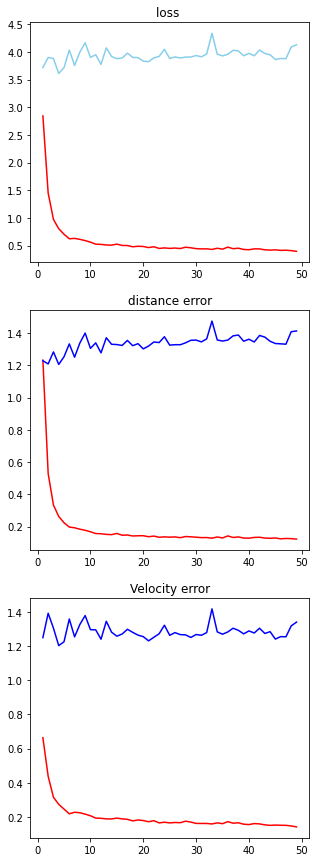

In [41]:

if __name__ == '__main__':

    batch_size = 32
    lr=1e-3
    #lr=1e-4#loss:11.72 10.74
    #lr=1e-3#9.6519
    #lr=0.01#8.3690
    #lr=0.1#8.2 7.72 7.71 ..7156.7147
    log_dir='/content/drive/My Drive/model042103highSNR.pth'
    #数据集加载
    dataset_path = '/content/drive/My Drive/'
    x_train, y_train, x_dev, y_dev = get_data(dataset_path, 'TrainData_MutiSNRnoMPI.mat', 0.2)
    #print(x_train[0])
    train_dataset = MyDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    dev_dataset = MyDataset(x_dev, y_dev)
    dev_loader = DataLoader(train_dataset, batch_size=batch_size)

    model = DnCNN()
    #model = Model()
    #模型加载
    start_epoch=0
    '''
    if os.path.exists(log_dir):
        checkpoint = torch.load(log_dir)
        model.load_state_dict(checkpoint['net'])
        start_epoch = checkpoint['epoch']
        print('加载 epoch {} 成功！'.format(start_epoch))
    else:
        start_epoch = 0
        print('无保存模型，将从头开始训练！')
    '''
    sgd = SGD(model.parameters(), lr)

    cost = CrossEntropyLoss()
    criterion = MSELoss(reduction='sum')
    epoch = 50
    use_GPU = True
    if use_GPU:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    epoch_train_loss_list = []
    epoch_dev_loss_list = []
    epoch_train_acc_list = []
    epoch_dev_acc_list = []
    epoch_train_derror_list = []
    epoch_dev_derror_list = []
    epoch_train_verror_list = []
    epoch_dev_verror_list = []
    for _epoch in range(start_epoch+1,start_epoch+epoch):
        model.train()
        epoch_train_loss = 0
        epoch_dev_loss = 0
        epoch_train_acc = 0
        epoch_dev_acc = 0
        train_num=0
        dev_num = 0
        epoch_dev_derror=0
        epoch_dev_verror=0
        epoch_train_derror=0
        epoch_train_verror=0
        epoch_train_mse=0
        for idx, (train_x, train_label) in enumerate(train_loader):
            s = train_label.shape[0]
            sgd.zero_grad()
            #print(train_x.size())
            predict_y = model(train_x.to(device))

            loss = criterion(predict_y, train_label.to(device))/ (2 * len(train_x))
            #loss = criterion(predict_y, train_label.to(device))
            terror,verror,acc,mse=vd_MSE(predict_y,train_label.to(device))
            epoch_train_mse+=mse
            epoch_train_loss += loss.item()
            epoch_train_derror+=terror
            epoch_train_verror+=verror
            epoch_train_acc+=acc
            label_pred = np.argmax(predict_y.cpu().data.numpy(), axis=1)
            #acc = np.sum(label_pred == train_label.numpy())
            # print("batch Train acc:",acc / s)
            #epoch_train_acc += acc / s
            train_num+=1
            loss.backward()
            sgd.step()

        correct = 0
        _sum = 0
        model.eval()

        with torch.no_grad():
            for idx, (dev_x, dev_label) in enumerate(dev_loader):
                s = dev_label.shape[0]
                predict_y = model(dev_x.to(device))
                # print(predict_y[0], dev_label[0])
                loss = criterion(predict_y, train_label.to(device)) / (2 * len(train_x))
                #loss = criterion(predict_y, train_label.to(device))
                terror,verror,acc,mse=vd_MSE(predict_y,train_label.to(device))
                
                epoch_dev_derror+=terror
                epoch_dev_verror+=verror
                epoch_dev_acc+=acc
                epoch_dev_loss += loss.item()
                label_pred = np.argmax(predict_y.cpu().data.numpy(), axis=1)
                # print("------")
                # print(label_pred)
                # print(dev_label.numpy())
                # print("------")
                #acc = np.sum(label_pred == dev_label.numpy())
                #batch_acc=acc / s
                dev_num+=1
                # print("batch_acc::",batch_acc)
                #epoch_dev_acc += acc / s
                # print("devacc", acc);
        epoch_train_loss_list.append(epoch_train_loss / train_num)
        epoch_dev_loss_list.append(epoch_dev_loss / dev_num)
        epoch_train_derror_list.append(epoch_train_derror / train_num)
        epoch_dev_derror_list.append(epoch_dev_derror / dev_num)
        epoch_train_verror_list.append(epoch_train_verror / train_num)
        epoch_dev_verror_list.append(epoch_dev_verror / dev_num)
        epoch_train_acc_list.append(epoch_train_acc / train_num)
        epoch_dev_acc_list.append(epoch_dev_acc / dev_num)

        #epoch_train_acc_list.append(epoch_train_acc / dev_num)
        #epoch_dev_acc_list.append(epoch_dev_acc / dev_num)
        print('-------------------------------------------------------------------------------------------------------------------------------------')
        print("epoch {:.4f} ,train loss: {:.4f}, dev loss: {:.4f},test mse: {:.4f}".format(_epoch, epoch_train_loss / train_num, epoch_dev_loss / dev_num,epoch_train_mse/train_num))
        print("epoch {:.4f} ,train derror: {:.4f}, dev derror: {:.4f}，train verror: {:.4f}, dev verror: {:.4f}".format(_epoch, epoch_train_derror / train_num, epoch_dev_derror / dev_num, epoch_train_verror / train_num, epoch_dev_verror / dev_num))
        print("epoch {:.4f} ,train acc: {:.4f}, dev acc: {:.4f}".format(_epoch, epoch_train_acc / train_num, epoch_dev_acc / dev_num))
        print('-------------------------------------------------------------------------------------------------------------------------------------')

    t = np.arange(1, len(epoch_train_loss_list) + 1)
    #模型保存
    
    state = {'net':model.state_dict(),  'epoch':epoch}
    torch.save(state, log_dir)

    plt.figure(figsize=(5,15))
    
    loss_plot = plt.subplot(3, 1, 1)
    plt.title('loss ')
    plt.plot(t, epoch_train_loss_list, color='red', label='train loss')
    plt.plot(t, epoch_dev_loss_list, color='skyblue', label='dev loss')
    der_plot = plt.subplot(3, 1, 2)
    plt.title('distance error')
    plt.plot(t, epoch_train_derror_list, color='red', label='train error')
    plt.plot(t, epoch_dev_derror_list, color='blue', label='dev error')
    der_plot = plt.subplot(3, 1, 3)
    plt.title('Velocity error')
    plt.plot(t, epoch_train_verror_list, color='red', label='train error')
    plt.plot(t, epoch_dev_verror_list, color='blue', label='dev error')
    plt.show()

In [ ]:
print(0:3)


SyntaxError: ignored

In [ ]:
    
    

t = np.arange(1, len(epoch_train_loss_list) + 1)
#模型保存
log_dir='/content/drive/My Drive/testCNN04201821.pth'
state = {'net':model.state_dict(),  'epoch':epoch}
torch.save(state, log_dir)

plt.figure(figsize=(5,15))

loss_plot = plt.subplot(3, 1, 1)
plt.title('loss ')
plt.plot(t, epoch_train_loss_list, color='red', label='train loss')
plt.plot(t, epoch_dev_loss_list, color='skyblue', label='dev loss')
der_plot = plt.subplot(3, 1, 2)
plt.title('distance error')
plt.plot(t, epoch_train_derror_list, color='red', label='train error')
plt.plot(t, epoch_dev_derror_list, color='blue', label='dev error')
der_plot = plt.subplot(3, 1, 3)
plt.title('Velocity error')
plt.plot(t, epoch_train_verror_list, color='red', label='train error')
plt.plot(t, epoch_dev_verror_list, color='blue', label='dev error')
plt.show()

NameError: ignored

In [ ]:
def get_test_data(dataset_path, fm, SNR):
    print("load data from path1:", dataset_path)
    data = scio.loadmat(os.path.join(dataset_path, fm))

    del data['__header__']
    del data['__globals__']
    del data['__version__']
    # print(x_data.keys())
    # print(y_data.keys())
    # print(int(len(x_data)/3))
    # datalen = int(len(x_data) / 3)
    datalen = 500
    x_test = np.zeros((datalen, 3, 50, 100), dtype=np.float)
    y_test = np.zeros((datalen, 6), dtype=np.float)
    for i in range(1, datalen):
        xkey = 'x' + str((SNR + 5) * 500+i)
        print(xkey)
        x_test[i] = data[xkey]

        ykey = 'y' + str((SNR + 5) * 500+i)
        y_test[i] = data[ykey]  # 噪声
        y_test[i]=y_test[i]/[100.,100.,100.,10000.,10000.,10000.]
        # if i==1:
        #  print(x[1])
        #  print(y_data[ykey])
        #  print(y[1])

    return x_test, y_test


In [ ]:
batch_size=100
model = DnCNN()

print(torch.cuda.is_available())
log_dir='/content/drive/My Drive/model.pth'
if os.path.exists(log_dir):
  checkpoint = torch.load(log_dir)
  model.load_state_dict(checkpoint['net'])
  start_epoch = checkpoint['epoch']
  print('加载 epoch {} 成功！'.format(start_epoch))
else:
    start_epoch = 0
    print('加载失败')

for SNR in range(-5,5):
  x_test, y_test = get_test_data(dataset_path, 'TrainData_MutiSNRnoMPI.mat', SNR)
  test_dataset = MyDataset(x_test, y_test)
  train_loader = DataLoader(test_dataset, batch_size=batch_size)

SNR_acc_list=[]
test_num=0
for idx, (test_x, test_label) in enumerate(train_loader):

  test_acc = 0
  epoch_dev_acc = 0
  train_num=0
  dev_num = 0
  epoch_dev_derror=0
  epoch_dev_verror=0
  epoch_train_derror=0
  epoch_train_verror=0
  s = test_label.shape[0]
  predict_y = model(test_x.to(device))
  # print(predict_y[0], dev_label[0])
  #loss = criterion(predict_y, train_label.to(device)) / (2 * len(train_x))
  terror,verror,acc=ab_err(predict_y,test_label.to(device))
  
  # print("------")
  # print(label_pred)
  # print(dev_label.numpy())
  # print("------")
  

  test_num+=1
  # print("batch_acc::",batch_acc)
  test_acc += acc
  test_derror+=terror
  test_verror+=verror
  
  
  # print("------")
  # print(label_pred)
  # print(dev_label.numpy())
  # print("------")
  #acc = np.sum(label_pred == dev_label.numpy())
  #batch_acc=acc / s
  test_num+=1
  # print("batch_acc::",batch_acc)
  #epoch_dev_acc += acc / s
  # print("devacc", acc);


SNR_acc_list.append(test_acc / test_num)


plt.figure(figsize=(5,5))
SNR=np.linspace(-5,5,10,endpoint=False)

plt.title('acc_SNR')
plt.plot(SNR, SNR_acc_list, color='red', label='train loss')

plt.show()

False


RuntimeError: ignored

In [ ]:
import numpy as np
L=np.linspace(-5,5,10,endpoint=False)
print(L)


[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
